wandb: Currently logged in as: cleanrl (use `wandb login --relogin` to force relogin)


Epoch 1/10
391/391 [==============================] - 1120s 3s/step - loss: 0.6928 - accuracy: 0.4972 - val_loss: 0.6908 - val_accuracy: 0.4917


wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7fcbd2b8f278>]


Epoch 2/10
391/391 [==============================] - 1109s 3s/step - loss: 0.6795 - accuracy: 0.5152 - val_loss: 0.5779 - val_accuracy: 0.6839
Epoch 3/10
391/391 [==============================] - 1118s 3s/step - loss: 0.5251 - accuracy: 0.7225 - val_loss: 0.4550 - val_accuracy: 0.7797
Epoch 4/10
391/391 [==============================] - 1115s 3s/step - loss: 0.4275 - accuracy: 0.8013 - val_loss: 0.4013 - val_accuracy: 0.8130
Epoch 5/10
391/391 [==============================] - 1106s 3s/step - loss: 0.3730 - accuracy: 0.8345 - val_loss: 0.3781 - val_accuracy: 0.8266
Epoch 6/10
391/391 [==============================] - 1110s 3s/step - loss: 0.3526 - accuracy: 0.8442 - val_loss: 0.3560 - val_accuracy: 0.8427
Epoch 7/10
391/391 [==============================] - 1119s 3s/step - loss: 0.3386 - accuracy: 0.8517 - val_loss: 0.3457 - val_accuracy: 0.8453
Epoch 8/10
391/391 [==============================] - 1113s 3s/step - loss: 0.3282 - accuracy: 0.8588 - val_loss: 0.3388 - val_accuracy:

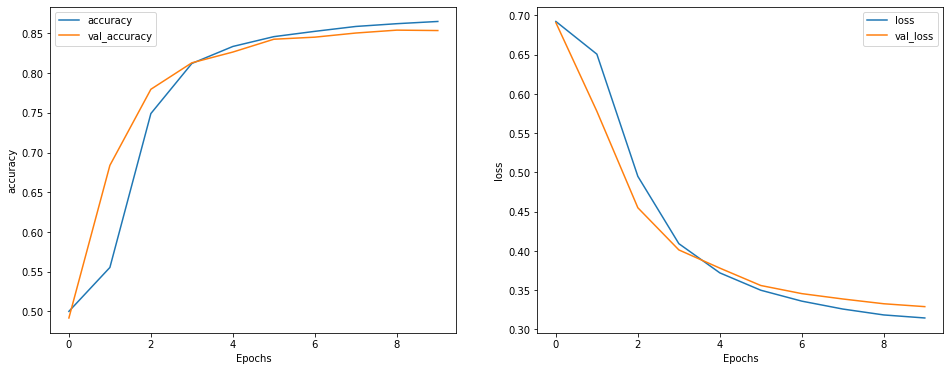

In [12]:
import numpy as np
import datetime
import tensorflow_datasets as tfds
import tensorflow as tf
!pip install wandb
!wandb login
import wandb
from wandb.integration.keras import WandbCallback
wandb.init(project='nlp', entity='bragajj', sync_tensorboard=True)

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])




dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

vocab = np.array(encoder.get_vocabulary())
vocab[:20]
##Bidirectional RNN
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
##Using ADAMAX rather than adam
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adamax(1e-4),
              metrics=['accuracy'])

log_dir = "logs/fit2021/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30, callbacks=[WandbCallback()])

test_loss, test_acc = model.evaluate(test_dataset)
wandb.log({'test_loss': test_loss, 'test_acc': test_acc})

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')


In [26]:
studenteval_text = ('He is intelligent and caring. He can be organized and logical as well. He is beginning to see how he must become a self starter. He is still having trouble working independently and getting work in on time. If he were to start in class, he could use the time to ask questions and get more done without the help of his dad. Also, he has a big heart yet protects it by being either mean, snarky, or pushing boundaries to fit in. He could practice being more kind to others AND HIMSELF. He is consistently late or missing classes/class time. I will hold He accountable for being on time and continue to help He with his own destructive self talk, I suck at this, I cant, etc. I will be making sure hes one on one sessions are work focused. He is starting to become acclimated to the Quadrat way. He is taking more interest and ownership of his actions and needs to level up his initiative.')
predictions = model.predict(np.array([studenteval_text]))
print(predictions)

[[2.7363958]]


In [27]:
!mkdir -p saved_2021model
model.save('saved_2021model/my_model')

INFO:tensorflow:Assets written to: saved_2021model/my_model/assets


INFO:tensorflow:Assets written to: saved_2021model/my_model/assets
